In [1]:
# dynamically determine project root and add it to sys.path
import sys
from pathlib import Path
notebook_dir = Path().resolve()
project_root = notebook_dir.parent
sys.path.insert(0, str(project_root))

In [2]:
from urllib.request import urlopen
import pandas as pd
import geopandas as gpd
from general_functions import load_data


# Load data

In [3]:
dfs = load_data('../data/EDA/')

# student region map

## exploring geoJSON files
I would like to create a map, showing where students are from. We will look at the regions, and try to find geoJSON data that fits.

In [4]:
df_studentinfo = dfs['studentinfo']
print(df_studentinfo['region'].unique())

['East Anglian Region' 'Scotland' 'North Western Region'
 'South East Region' 'West Midlands Region' 'Wales' 'North Region'
 'South Region' 'Ireland' 'South West Region' 'East Midlands Region'
 'Yorkshire Region' 'London Region']


I found geoJSON datasets, visualised on [https://martinjc.github.io/UK-GeoJSON/](https://martinjc.github.io/UK-GeoJSON/). They seem to be corresponding rather well.


     EER13CD EER13CDO                   EER13NM  \
0  E15000001       01                North East   
1  E15000002       02                North West   
2  E15000003       03  Yorkshire and The Humber   
3  E15000004       04             East Midlands   
4  E15000005       05             West Midlands   

                                            geometry  
0  MULTIPOLYGON (((-1.22318 54.62577, -1.22502 54...  
1  MULTIPOLYGON (((-3.20507 53.37188, -3.20395 53...  
2  MULTIPOLYGON (((-0.55371 53.69031, -0.5464 53....  
3  MULTIPOLYGON (((0.23432 52.82331, 0.23868 52.8...  
4  POLYGON ((-1.95073 53.21189, -1.94881 53.21165...  


<Axes: >

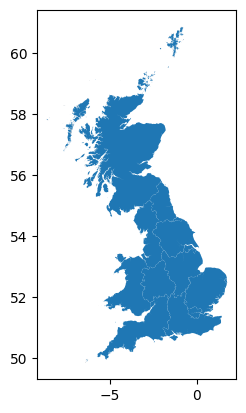

In [6]:
# get geoJSOn files
# GB
gdfGB = gpd.GeoDataFrame.from_file('https://raw.githubusercontent.com/martinjc/UK-GeoJSON/refs/heads/master/json/electoral/gb/eer.json')
print(gdfGB.head())
gdfGB.plot()

We will be needing 'EER13NM' to identify the regions.

In [7]:
gdfGB['EER13NM'].tolist()

['North East',
 'North West',
 'Yorkshire and The Humber',
 'East Midlands',
 'West Midlands',
 'Eastern',
 'London',
 'South East',
 'South West',
 'Scotland',
 'Wales']

In [8]:
regions_mapping = {
    'North East': 'North East',
    'East Anglian Region': 'Eastern',
    'Scotland': 'Scotland',
    'North Western Region': 'North West',
    'South East Region': 'South East',
    'West Midlands Region': 'West Midlands',
    'Wales': 'Wales',
    'North Region': None,
    'South Region': None,
    'Ireland': None,
    'South West Region': 'South West',
    'East Midlands Region': 'East Midlands',
    'Yorkshire Region': 'Yorkshire and The Humber',
    'London Region': 'London'
    }

We're missing 'North Region', 'South Region', and 'Ireland'. 'North East' exists on the map, but not in our data. North Region and South Region seems a less granular division of England. Ireland is missing. We'll first look for Ireland.

        ID                         NAME     Area_SqKM  OBJECTID  \
0  6834691  Outline of Northern Ireland  13594.044105         1   

                                            geometry  
0  MULTIPOLYGON (((-7.85051 54.533, -7.85057 54.5...  


<Axes: >

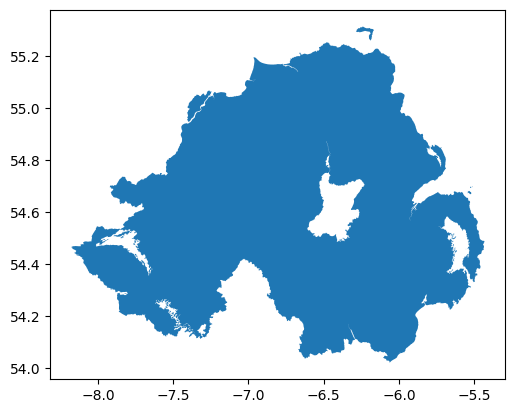

In [9]:
# get geoJSOn files
# Northern Ireland
gdfNI = gpd.GeoDataFrame.from_file('https://raw.githubusercontent.com/martinjc/UK-GeoJSON/refs/heads/master/json/electoral/ni/eer.json')
print(gdfNI.head())
gdfNI.plot()

Here we'll be needing 'NAME' to identify the region (instead of 'EER13NM'). Let's just use 'region' for all instead.

In [10]:
gdfGB.rename(columns={"EER13NM": "region"}, inplace=True)
gdfNI.rename(columns={"NAME": "region"}, inplace=True)

## combining regions
Let's combine both JSON files

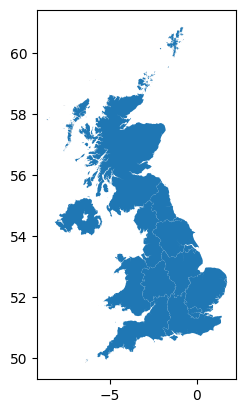

In [11]:
# Combine the two GeoDataFrames
combined_gdf = gpd.GeoDataFrame(pd.concat([gdfGB, gdfNI], ignore_index=True))
combined_gdf.plot()

# Save the combined GeoDataFrame to a new GeoJSON file in data folder
combined_gdf.to_file('../data/allregions.geojson', driver='GeoJSON')


In [12]:
# Let's verify if we have all regions
combined_gdf['region']

0                      North East
1                      North West
2        Yorkshire and The Humber
3                   East Midlands
4                   West Midlands
5                         Eastern
6                          London
7                      South East
8                      South West
9                        Scotland
10                          Wales
11    Outline of Northern Ireland
Name: region, dtype: object

In [13]:
# update region mapping
regions_mapping['Ireland'] = 'Outline of Northern Ireland'

## grouping regions

We'll create a second mapping, mapping the granular English regions based on the [North–South divide in England](https://en.wikipedia.org/wiki/North%E2%80%93South_divide_in_England).

In [14]:
regions_mapping_combined = {'North East': 'North Region',
                            'Eastern': 'South Region',
                            'Scotland': 'Scotland',
                            'North West': 'North Region',
                            'South East': 'South Region',
                            'West Midlands': 'West Midlands',
                            'Wales': 'Wales',
                            'Outline of Northern Ireland': 'Outline of Northern Ireland',
                            'South West': 'South Region',
                            'East Midlands': 'East Midlands',
                            'Yorkshire and The Humber': 'North Region',
                            'London': 'South Region'
                            }

In [15]:
# add group to each region
combined_gdf.loc[:,'group'] = combined_gdf['region'].map(regions_mapping_combined)
# drop irrelevant columns
combined_gdf.drop(['EER13CD', 'EER13CDO', 'ID', 'Area_SqKM','OBJECTID'], axis=1, inplace=True)
combined_gdf

,region,geometry,group
0,North East,"MULTIPOLYGON (((-1.22318 54.62577, -1.22502 54...",North Region
1,North West,"MULTIPOLYGON (((-3.20507 53.37188, -3.20395 53...",North Region
2,Yorkshire and The Humber,"MULTIPOLYGON (((-0.55371 53.69031, -0.5464 53....",North Region
3,East Midlands,"MULTIPOLYGON (((0.23432 52.82331, 0.23868 52.8...",East Midlands
4,West Midlands,"POLYGON ((-1.95073 53.21189, -1.94881 53.21165...",West Midlands
5,Eastern,"MULTIPOLYGON (((0.54014 51.51765, 0.53953 51.5...",South Region
6,London,"MULTIPOLYGON (((-0.32103 51.446, -0.32493 51.4...",South Region
7,South East,"MULTIPOLYGON (((-1.5888 50.66271, -1.5893 50.6...",South Region
8,South West,"MULTIPOLYGON (((-6.39901 49.86525, -6.39889 49...",South Region
9,Scotland,"MULTIPOLYGON (((-4.41211 54.68063, -4.41274 54...",Scotland


In [16]:
# create mapping from region in data to group in geoJSON
map_data_to_group = {key: regions_mapping_combined[value] if value else key for key, value in regions_mapping.items()}

In [17]:
grouped_gdf = combined_gdf.dissolve(by='group').reset_index()
grouped_gdf['region'] = grouped_gdf['group']
grouped_gdf.drop('group', axis=1, inplace=True)
grouped_gdf

,geometry,region
0,"MULTIPOLYGON (((0.24481 52.82195, 0.24524 52.8...",East Midlands
1,"MULTIPOLYGON (((-3.20623 53.37099, -3.20725 53...",North Region
2,"MULTIPOLYGON (((-7.42951 54.16087, -7.42946 54...",Outline of Northern Ireland
3,"MULTIPOLYGON (((-7.64974 56.78414, -7.64984 56...",Scotland
4,"MULTIPOLYGON (((-6.39901 49.86525, -6.39889 49...",South Region
5,"MULTIPOLYGON (((-5.11718 51.69183, -5.11725 51...",Wales
6,"POLYGON ((-1.95073 53.21189, -1.94881 53.21165...",West Midlands


In [ ]:
# save file
grouped_gdf.to_file('../data/allregions_grouped.geojson', 
                    driver='GeoJSON')